Notebook is heavily based on this work:
    
https://www.pyimagesearch.com/2017/12/11/image-classification-with-keras-and-deep-learning/

Load required libraries

In [1]:
from keras.models import Sequential
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dense
from keras.layers.core import Dropout
from keras import backend as K
from keras.models import load_model

Using Theano backend.


In [2]:
%matplotlib inline

In [3]:
from IPython.display import Image

In [4]:
 # import the necessary packages
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.optimizers import SGD
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import img_to_array
from keras.utils import to_categorical
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import random
import cv2
import os

load functions for to gather images into a dataset

In [5]:
from imagePreparation import buildImagePaths, gatherData

In [6]:
pathToMarsImages = "C:\Users\\battlann\Documents\work\CNNpres\marsBar\\"
pathToNotMarsImages = "C:\Users\\battlann\Documents\work\CNNpres\\notMarsBar\\"

In [7]:
imgPaths = buildImagePaths(pathToMarsImages)
imgPaths += buildImagePaths(pathToNotMarsImages)
imagePaths = sorted(imgPaths)
data, labels = gatherData(imgPaths)

In [8]:
len(imgPaths)

2574

In [9]:
%%time
data, labels = gatherData(imgPaths)

Wall time: 46.2 s


split dataset into train and test. Teach model om Train, validate the result on Test

In [10]:
(trainX, testX, trainY, testY) = train_test_split(data,labels, test_size=0.25, random_state=42)

transform class labels (mars, notMars) into format, suitable for Keras model

In [11]:
trainY = to_categorical(trainY, num_classes=2)
testY = to_categorical(testY, num_classes=2)

function to describe the network

In [26]:
def buildModel(width, height, depth, classes):
		# initialize the model
		model = Sequential()
		inputShape = (height, width, depth)
 
		# if we are using "channels first", update the input shape
		if K.image_data_format() == "channels_first":
			inputShape = (depth, height, width)
		# first set of CONV => RELU => POOL layers
		model.add(Conv2D(20, (5, 5), padding="same",
			input_shape=inputShape))
		model.add(Activation("relu"))
		model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
		# second set of CONV => RELU => POOL layers
		model.add(Conv2D(50, (5, 5), padding="same"))
		model.add(Activation("relu"))
		model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
		# third set of CONV => RELU => POOL layers
		model.add(Conv2D(50, (5, 5), padding="same"))
		model.add(Activation("relu"))
		model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
		# first (and only) set of FC => RELU layers
		model.add(Flatten())
		model.add(Dense(500))
		model.add(Activation("relu"))
 
		# softmax classifier
		model.add(Dense(classes))
		model.add(Activation("softmax"))
 
		# return the constructed network architecture
		return model

number of epochs to learn, speed of learning and number of images to fit in memory at once

In [27]:
EPOCHS = 60
INIT_LR = 1e-3
BS = 32

A trick to distort images, so there is a wider variety of features availale for the model

In [28]:
aug = ImageDataGenerator(rotation_range=30, width_shift_range=0.1,
	height_shift_range=0.1, shear_range=0.2, zoom_range=0.2,
	horizontal_flip=True, fill_mode="nearest")

Build and compile the model. Use Adam algorithm for Loss optimization, Binary crossentropy Loss function

In [29]:
model = buildModel(width=48, height=48, depth=3, classes=2)
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

check model structure

In [30]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 48, 48, 20)        1520      
_________________________________________________________________
activation_5 (Activation)    (None, 48, 48, 20)        0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 24, 24, 20)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 24, 24, 50)        25050     
_________________________________________________________________
activation_6 (Activation)    (None, 24, 24, 50)        0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 12, 12, 50)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 12, 12, 50)        62550     
__________

finally, fit the model! It will take about 25 minutes.

In [31]:
%%time
H = model.fit_generator(aug.flow(trainX, trainY, batch_size=BS),
	validation_data=(testX, testY), steps_per_epoch=len(trainX) // BS,
	epochs=60, verbose=2)

Epoch 1/60
 - 17s - loss: 0.4058 - acc: 0.8488 - val_loss: 0.3396 - val_acc: 0.8742
Epoch 2/60
 - 17s - loss: 0.3215 - acc: 0.8708 - val_loss: 0.3052 - val_acc: 0.8866
Epoch 3/60
 - 16s - loss: 0.3079 - acc: 0.8869 - val_loss: 0.3143 - val_acc: 0.8960
Epoch 4/60
 - 18s - loss: 0.2780 - acc: 0.8964 - val_loss: 0.3011 - val_acc: 0.9130
Epoch 5/60
 - 16s - loss: 0.2580 - acc: 0.9055 - val_loss: 0.2468 - val_acc: 0.9115
Epoch 6/60
 - 17s - loss: 0.2209 - acc: 0.9186 - val_loss: 0.2514 - val_acc: 0.9208
Epoch 7/60
 - 17s - loss: 0.1948 - acc: 0.9333 - val_loss: 0.2794 - val_acc: 0.8960
Epoch 8/60
 - 17s - loss: 0.2593 - acc: 0.9088 - val_loss: 0.2141 - val_acc: 0.9255
Epoch 9/60
 - 17s - loss: 0.1907 - acc: 0.9312 - val_loss: 0.2175 - val_acc: 0.9332
Epoch 10/60
 - 16s - loss: 0.1612 - acc: 0.9448 - val_loss: 0.1755 - val_acc: 0.9488
Epoch 11/60
 - 17s - loss: 0.1744 - acc: 0.9359 - val_loss: 0.2779 - val_acc: 0.8758
Epoch 12/60
 - 19s - loss: 0.1666 - acc: 0.9432 - val_loss: 0.1774 - val_a

save model to file for future use

In [32]:
model.save('marsModelCNN3layer.h5')

In [20]:
#model = load_model('marsModelCNN3layer.h5')

Check if Loss function goes down and accuracy goes up

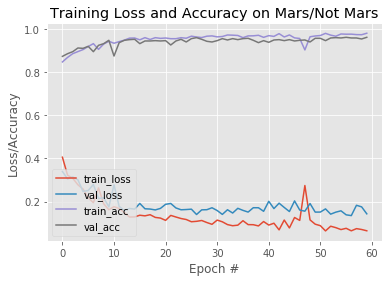

In [33]:
# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()
N = EPOCHS
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["acc"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy on Mars/Not Mars")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig('3layerLoss.png')

Check mean accuracy for last iterations

In [49]:
np.mean(H.history["val_acc"][50:60])

0.95854037220803856

Check if CNN can recognise *unseen* Mars pictures

In [50]:
def predictHomeMadeCnn(pathToFile):
    image = cv2.imread(pathToFile)
    image = cv2.resize(image, (48, 48))
    image = img_to_array(image)
    image = np.expand_dims(image, axis=0)
    yhat = model.predict(image)
    print "probability Mars: {}".format(yhat[0][1])
    print "probability not Mars: {}".format(yhat[0][0])
    return None

In [33]:
#Image("C:\Users\\battlann\Documents\work\CNNpres\\test\\babaevskiy_batochnik_s_shokoladnoy_nachinkoy.jpg")

In [46]:
predictHomeMadeCnn("C:\Users\\battlann\Documents\work\CNNpres\\test\\babaevskiy_batochnik_s_shokoladnoy_nachinkoy.jpg")

probability Mars: 0.0
probability notMars: 1.0


Save a picture of the model

In [47]:
from keras.utils import plot_model

In [48]:
plot_model(model, to_file='model.png')